# Fidelity Evaluation of Synthetic Data

This notebook evaluates **how closely the synthetic data resembles real-world data** in terms of statistical and linguistic properties.

Key Steps:  
- Load three datasets:
  - **Real dataset** (`train.jsonl`)
  - **Non-DP synthetic dataset** (`generated_sequences_no_dp.jsonl`)
  - **DP-synthetic dataset** (`generated_sequences_with_dp.jsonl`)
- Compare **token distributions, sentence structures, and statistical features**.
- Use **feature extraction techniques** to measure similarities between datasets.

This analysis ensures that **synthetic data maintains the statistical properties of real data** while respecting privacy constraints.


## Setup and Data Preparation

First, load the datasets and prepare them for analysis whihc are in jsonl format.

Steps:
1. Load real, synthetic, and DP-synthetic review data.
2. Split the real dataset into training and test subsets for modeling (80/20 split, stratified by label to maintain class balance).

In [1]:
input_file = 'train.jsonl'
output_file = 'real_reviews.jsonl'
n_rows = 10000

with open(input_file, 'r') as fin, open(output_file, 'w') as fout:
    for i, line in enumerate(fin):
        if i >= n_rows:
            break
        fout.write(line)


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Define a parsing function that splits by " | " and extracts Rating, Title, and Review
def parse_synth_line(line):
    # Split the line using the " | " delimiter
    parts = line.split(" | ")
    if len(parts) < 4:
        return {}
    # Extract rating: assume format: '"Rating": 4'
    rating_str = parts[1].partition(':')[2].strip()
    try:
        rating = int(rating_str)
    except ValueError:
        rating = None

    # Extract title: assume format: '"Title": Some Title'
    title = parts[2].partition(':')[2].strip()

    # Extract review: join any remaining parts (in case '|' appears in the review), then partition on the colon.
    review_full = " | ".join(parts[3:])
    review = review_full.partition(':')[2].strip()

    return {"rating": rating, "title": title, "review": review}

# Function to load a pipe-delimited jsonl file
def load_pipe_delimited_jsonl(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parsed = parse_synth_line(line)
            # Only add if parsed successfully
            if parsed.get("rating") is not None and parsed.get("review") is not None:
                data.append(parsed)
    return pd.DataFrame(data)

# Load real data from a standard jsonl file
def load_and_standardize_jsonl(file_path):
    df = pd.read_json(file_path, lines=True)
    # Standardize column names to lower-case
    df.columns = [col.lower().strip() for col in df.columns]
    return df

# Load datasets
real_df      = load_and_standardize_jsonl('real_reviews.jsonl')
synth_df     = load_pipe_delimited_jsonl('synthetic_reviews.jsonl')
dp_synth_df  = load_pipe_delimited_jsonl('dp_synthetic_reviews.jsonl')

# Process labels: drop neutral reviews (rating==3) and create binary sentiment (4-5 => 1, 1-2 => 0)
def process_labels(df):
    if 'rating' in df.columns:
        # df.drop(df[df['rating'] == 3].index, inplace=True)
        df['label'] = (df['rating'] >= 4).astype(int)
    elif 'label' in df.columns:
        df['label'] = df['label'].astype(int)
    else:
        raise ValueError("Datasets must have a 'rating' or 'label' column for utility evaluation.")
    return df

real_df     = process_labels(real_df)
synth_df    = process_labels(synth_df)
dp_synth_df = process_labels(dp_synth_df)

# Reset indices after processing
real_df.reset_index(drop=True, inplace=True)
synth_df.reset_index(drop=True, inplace=True)
dp_synth_df.reset_index(drop=True, inplace=True)

# Split real data into train/test for model evaluation
train_texts, test_texts, train_labels, test_labels = train_test_split(
    real_df['review'].astype(str).tolist(),
    real_df['label'].tolist(),
    test_size=0.2,
    stratify=real_df['label'],
    random_state=42
)

print(f"Real dataset: {len(real_df)} reviews ({sum(real_df['label'] == 1)} positive, {sum(real_df['label'] == 0)} negative)")
print(f"Synthetic (non-DP) dataset: {len(synth_df)} reviews")
print(f"DP-Synthetic dataset: {len(dp_synth_df)} reviews")
print(f"Real train/test split: {len(train_texts)} train, {len(test_texts)} test")


Real dataset: 10000 reviews (7802 positive, 2198 negative)
Synthetic (non-DP) dataset: 10000 reviews
DP-Synthetic dataset: 10000 reviews
Real train/test split: 8000 train, 2000 test


In [3]:
# Print overall counts
print(f"Real dataset: {len(real_df)} reviews ({sum(real_df['label'] == 1)} positive, {sum(real_df['label'] == 0)} negative)")
print(f"Synthetic (non-DP) dataset: {len(synth_df)} reviews")
print(f"DP-Synthetic dataset: {len(dp_synth_df)} reviews")
print(f"Real train/test split: {len(train_texts)} train, {len(test_texts)} test\n")

# Print distribution of positive and negative reviews for each dataset
print("Real dataset distribution (positive vs negative):")
print(real_df['label'].value_counts())
print("\nSynthetic (non-DP) dataset distribution (positive vs negative):")
print(synth_df['label'].value_counts())
print("\nDP-Synthetic dataset distribution (positive vs negative):")
print(dp_synth_df['label'].value_counts())
synth_df

Real dataset: 10000 reviews (7802 positive, 2198 negative)
Synthetic (non-DP) dataset: 10000 reviews
DP-Synthetic dataset: 10000 reviews
Real train/test split: 8000 train, 2000 test

Real dataset distribution (positive vs negative):
label
1    7802
0    2198
Name: count, dtype: int64

Synthetic (non-DP) dataset distribution (positive vs negative):
label
1    7802
0    2198
Name: count, dtype: int64

DP-Synthetic dataset distribution (positive vs negative):
label
1    7802
0    2198
Name: count, dtype: int64


,rating,title,review,label
0,4,No white background! It\u2019s clear!,Angeles and the white background is clear. I t...,1
1,5,Awesome! Great price! Works well!,://i.imgur.com/tj5p1Xq<br /><br />Works great ...,1
2,5,Worked but took an hour to install,://en.wikipedia.org/2019/2/21/How_to_install_s...,1
3,4,Decent,":// Decent case. It works, it\u2019s a nice ...",1
4,5,LOVE IT!,"\""Love it! Very pretty and fits perfectly. I...",1
...,...,...,...,...
9995,5,"This is a Winner\u2026.or so, I thought - Upd...","\""Good case but the stand on the back broke of...",1
9996,5,Great Holder Especially for Iphones Pro Max,"\""Easy to use, good suction cup, easy to insta...",1
9997,3,Spectre Shield used for Fitbit Sense - Scratch...,://2022/09/14<br />I purchased this screen pro...,0
9998,3,Great Stand but not for Apple Watch 4,Angeles is a great stand and works great for m...,0


In [4]:
dp_synth_df

,rating,title,review,label
0,4,No white background! It\u2019s clear!,:// The screen protector is clear and does not...,1
1,5,Awesome! Great price! Works well!,://5 stars//Great product. Great price. Work...,1
2,5,Worked but took an hour to install,:// The screen protector did not stick to the ...,1
3,4,Decent,:// This is a decent case. It is a little bulk...,1
4,5,LOVE IT!,://\\n\\nI love this case. I have the black ca...,1
...,...,...,...,...
9995,5,"This is a Winner\u2026.or so, I thought - Upd...","5 stars for the price, fit, and finish. I real...",1
9996,5,Great Holder Especially for Iphones Pro Max,://The holder works great for my Iphone Pro Ma...,1
9997,3,Spectre Shield used for Fitbit Sense - Scratch...,:// I bought this to use with my Fitbit Sense...,0
9998,3,Great Stand but not for Apple Watch 4,://This stand is great for my Apple Watch 3 bu...,0


In [5]:
real_df

,system prompt,rating,title,review,label
0,"Given the Rating and Title, you are required t...",4,No white background! It’s clear!,I bought this bc I thought it had the nice whi...,1
1,"Given the Rating and Title, you are required t...",5,Awesome! Great price! Works well!,Perfect. How pissed am I that I recently paid ...,1
2,"Given the Rating and Title, you are required t...",5,Worked but took an hour to install,Overall very happy with the end result. If you...,1
3,"Given the Rating and Title, you are required t...",4,Decent,Lasted about 9 months then the lock button bro...,1
4,"Given the Rating and Title, you are required t...",5,LOVE IT!,LOVE THIS CASE! Works better than my expensive...,1
...,...,...,...,...,...
9995,"Given the Rating and Title, you are required t...",5,"This is a Winner….or so, I thought - Updated ...",This is an update as of 9/13/2021<br /><br />I...,1
9996,"Given the Rating and Title, you are required t...",5,Great Holder Especially for Iphones Pro Max,"Love, love, love this cell phone holder. I ow...",1
9997,"Given the Rating and Title, you are required t...",3,Spectre Shield used for Fitbit Sense - Scratch...,There is not much of a selection out there whe...,0
9998,"Given the Rating and Title, you are required t...",3,Great Stand but not for Apple Watch 4,I truly loved this little stand. It was conven...,0


In [6]:
import re

def clean_review_text(text):
    # Replace newline characters with a space
    text = text.replace('\n', ' ').replace('\r', ' ')
    # Remove backslashes
    text = text.replace('\\', '')
    # Remove any leading characters that are colons, forward slashes, or whitespace
    text = re.sub(r'^[\s:/]+', '', text)
    # Normalize multiple spaces into a single space
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Apply the cleaning function to the review column for each dataset
real_df['review'] = real_df['review'].apply(clean_review_text)
synth_df['review'] = synth_df['review'].apply(clean_review_text)
dp_synth_df['review'] = dp_synth_df['review'].apply(clean_review_text)

# Optionally, print a few cleaned examples to verify
print(real_df['review'].head())
print(synth_df['review'].head())
print(dp_synth_df['review'].head())


0    I bought this bc I thought it had the nice whi...
1    Perfect. How pissed am I that I recently paid ...
2    Overall very happy with the end result. If you...
3    Lasted about 9 months then the lock button bro...
4    LOVE THIS CASE! Works better than my expensive...
Name: review, dtype: object
0    Angeles and the white background is clear. I t...
1    i.imgur.com/tj5p1Xq<br /><br />Works great and...
2    en.wikipedia.org/2019/2/21/How_to_install_scre...
3    Decent case. It works, itu2019s a nice color, ...
4    "Love it! Very pretty and fits perfectly. I ha...
Name: review, dtype: object
0    The screen protector is clear and does not hav...
1    5 stars//Great product. Great price. Works wel...
2    The screen protector did not stick to the phon...
3    This is a decent case. It is a little bulky, b...
4    nnI love this case. I have the black case and ...
Name: review, dtype: object


In [7]:
dp_synth_df

,rating,title,review,label
0,4,No white background! It\u2019s clear!,The screen protector is clear and does not hav...,1
1,5,Awesome! Great price! Works well!,5 stars//Great product. Great price. Works wel...,1
2,5,Worked but took an hour to install,The screen protector did not stick to the phon...,1
3,4,Decent,"This is a decent case. It is a little bulky, b...",1
4,5,LOVE IT!,nnI love this case. I have the black case and ...,1
...,...,...,...,...
9995,5,"This is a Winner\u2026.or so, I thought - Upd...","5 stars for the price, fit, and finish. I real...",1
9996,5,Great Holder Especially for Iphones Pro Max,The holder works great for my Iphone Pro Max. ...,1
9997,3,Spectre Shield used for Fitbit Sense - Scratch...,I bought this to use with my Fitbit Sense. The...,0
9998,3,Great Stand but not for Apple Watch 4,This stand is great for my Apple Watch 3 but i...,0


## Metric 1 - Fidelity Evaluation
We measure how faithfully the synthetic data replicates the characteristics of real data.

Key aspects include textual length distributions, semantic embeddings distribution, and statistical divergence metrics.

Fidelity evaluation steps:
1. Length Distributions: Compare sentence length and review length (paragraph length) distributions between datasets.
2. Embedding Distribution: Use a pre-trained Sentence-BERT model to get vector embeddings of reviews and compare distributions between real and synthetic (e.g., via cosine similarity and Fréchet Distance).
3. Cosine Similarity & Fréchet Distance: Quantify overlap of synthetic vs. real in embedding space using average nearest-neighbor cosine similarity and Fréchet distance between embedding distributions.
4. Sample for Human Evaluation: Randomly sample 5% of reviews from each dataset for manual inspection of fidelity (saved for review).
5. Jensen-Shannon Divergence (JSD): Compute JSD between real and synthetic word distributions as an alternate measure of distribution similarity.

### 1.1 average lengths

In [8]:
import numpy as np

def length_stats(texts):
    """Compute length distribution stats: words per review, words per sentence, sentences per review."""
    sentence_lengths = []
    review_lengths_words = []
    review_lengths_sentences = []
    for text in texts:
        # Split into sentences (roughly, using punctuation delimiters)
        sentences = [s.strip() for s in text.replace('?', '.').replace('!', '.').split('.') if s.strip()]
        review_lengths_sentences.append(len(sentences))
        # Count words in the whole review
        words = text.split()
        review_lengths_words.append(len(words))
        # Count words in each sentence
        for s in sentences:
            sentence_lengths.append(len(s.split()))
    # Compute summary stats
    def summarize(arr):
        return {
            'mean': float(np.mean(arr)),
            'median': float(np.median(arr)),
            'std': float(np.std(arr)),
            'min': int(np.min(arr)),
            'max': int(np.max(arr)),
            '90perc': float(np.percentile(arr, 90))
        }
    return {
        'review_words': summarize(np.array(review_lengths_words)),
        'review_sentences': summarize(np.array(review_lengths_sentences)),
        'sentence_words': summarize(np.array(sentence_lengths))
    }

# Compute length stats for each dataset
real_texts   = real_df['review'].astype(str).tolist()
synth_texts  = synth_df['review'].astype(str).tolist()
dp_synth_texts = dp_synth_df['review'].astype(str).tolist()

stats_real    = length_stats(real_texts)
stats_synth   = length_stats(synth_texts)
stats_dp_synth = length_stats(dp_synth_texts)

# Print out a few comparisons
print("Average review length (words): Real = {:.1f}, Synth = {:.1f}, DP-Synth = {:.1f}"
      .format(stats_real['review_words']['mean'], stats_synth['review_words']['mean'], stats_dp_synth['review_words']['mean']))
print("Average sentence length (words): Real = {:.1f}, Synth = {:.1f}, DP-Synth = {:.1f}"
      .format(stats_real['sentence_words']['mean'], stats_synth['sentence_words']['mean'], stats_dp_synth['sentence_words']['mean']))
print("Median review length (words): Real = {}, Synth = {}, DP-Synth = {}"
      .format(stats_real['review_words']['median'], stats_synth['review_words']['median'], stats_dp_synth['review_words']['median']))


Average review length (words): Real = 58.8, Synth = 52.3, DP-Synth = 51.7
Average sentence length (words): Real = 13.4, Synth = 7.1, DP-Synth = 9.0
Median review length (words): Real = 28.0, Synth = 54.0, DP-Synth = 57.0


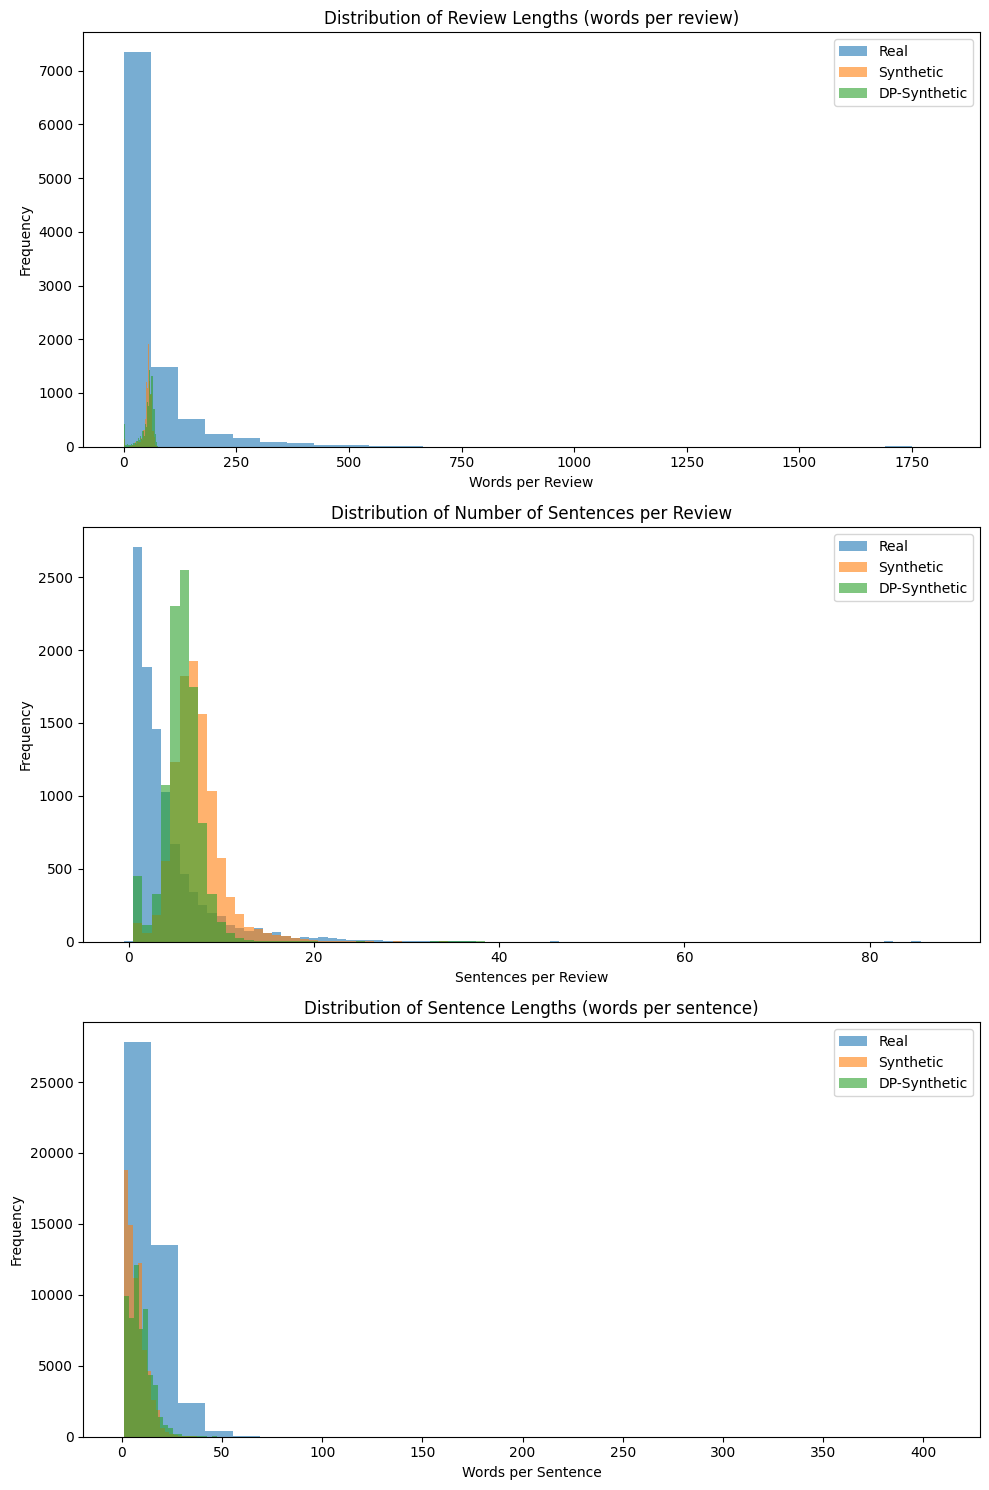

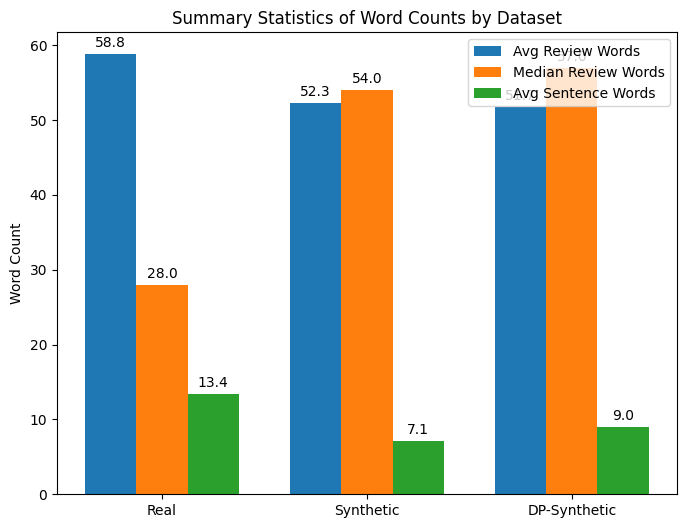

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Helper function to compute length arrays from a list of texts
def compute_length_arrays(texts):
    review_lengths_words = []      # Number of words per review
    review_lengths_sentences = []  # Number of sentences per review
    sentence_lengths = []          # Number of words per sentence
    for text in texts:
        # Split into sentences (roughly, using punctuation delimiters)
        sentences = [s.strip() for s in text.replace('?', '.').replace('!', '.').split('.') if s.strip()]
        review_lengths_sentences.append(len(sentences))
        # Count words in the whole review
        words = text.split()
        review_lengths_words.append(len(words))
        # Count words in each sentence
        for s in sentences:
            sentence_lengths.append(len(s.split()))
    return review_lengths_words, review_lengths_sentences, sentence_lengths

# Compute arrays for each dataset
rw_real, rs_real, sw_real   = compute_length_arrays(real_texts)
rw_synth, rs_synth, sw_synth = compute_length_arrays(synth_texts)
rw_dp, rs_dp, sw_dp          = compute_length_arrays(dp_synth_texts)

# -------------------------------------------------------------------------
# 1. Create histograms for the distributions in a 3-row subplot
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Histogram of review lengths (words per review)
axes[0].hist(rw_real, bins=30, alpha=0.6, label='Real', color='tab:blue')
axes[0].hist(rw_synth, bins=30, alpha=0.6, label='Synthetic', color='tab:orange')
axes[0].hist(rw_dp, bins=30, alpha=0.6, label='DP-Synthetic', color='tab:green')
axes[0].set_title('Distribution of Review Lengths (words per review)')
axes[0].set_xlabel('Words per Review')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Histogram of number of sentences per review
# Use integer bins for sentence counts
max_sentences = max(max(rs_real), max(rs_synth), max(rs_dp))
bins_sentences = np.arange(0, max_sentences + 2) - 0.5  # shift bins for integer alignment

axes[1].hist(rs_real, bins=bins_sentences, alpha=0.6, label='Real', color='tab:blue')
axes[1].hist(rs_synth, bins=bins_sentences, alpha=0.6, label='Synthetic', color='tab:orange')
axes[1].hist(rs_dp, bins=bins_sentences, alpha=0.6, label='DP-Synthetic', color='tab:green')
axes[1].set_title('Distribution of Number of Sentences per Review')
axes[1].set_xlabel('Sentences per Review')
axes[1].set_ylabel('Frequency')
axes[1].legend()

# Histogram of sentence lengths (words per sentence)
axes[2].hist(sw_real, bins=30, alpha=0.6, label='Real', color='tab:blue')
axes[2].hist(sw_synth, bins=30, alpha=0.6, label='Synthetic', color='tab:orange')
axes[2].hist(sw_dp, bins=30, alpha=0.6, label='DP-Synthetic', color='tab:green')
axes[2].set_title('Distribution of Sentence Lengths (words per sentence)')
axes[2].set_xlabel('Words per Sentence')
axes[2].set_ylabel('Frequency')
axes[2].legend()

plt.tight_layout()
plt.show()

# -------------------------------------------------------------------------
# 2. Create a bar chart comparing summary statistics for each dataset
# Using the previously computed stats from length_stats
labels = ['Real', 'Synthetic', 'DP-Synthetic']
avg_review_words = [stats_real['review_words']['mean'],
                    stats_synth['review_words']['mean'],
                    stats_dp_synth['review_words']['mean']]
median_review_words = [stats_real['review_words']['median'],
                       stats_synth['review_words']['median'],
                       stats_dp_synth['review_words']['median']]
avg_sentence_words = [stats_real['sentence_words']['mean'],
                      stats_synth['sentence_words']['mean'],
                      stats_dp_synth['sentence_words']['mean']]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width, avg_review_words, width, label='Avg Review Words')
rects2 = ax.bar(x, median_review_words, width, label='Median Review Words')
rects3 = ax.bar(x + width, avg_sentence_words, width, label='Avg Sentence Words')

ax.set_ylabel('Word Count')
ax.set_title('Summary Statistics of Word Counts by Dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to add labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()


In [10]:
# Install sentence-transformers if not available (Colab usually requires this)
try:
    from sentence_transformers import SentenceTransformer
except ImportError:
    !pip install -q sentence-transformers
    from sentence_transformers import SentenceTransformer

# Load a Sentence-BERT model for embeddings
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')  # a lightweight Sentence-BERT model

def compute_embeddings(texts, batch_size=1000):
    """Compute sentence embeddings for a list of texts in batches to avoid memory issues."""
    all_embeds = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        emb_batch = model.encode(batch, show_progress_bar=False)
        all_embeds.append(emb_batch)
    return np.vstack(all_embeds)

# Compute embeddings for each dataset (this may be time-consuming for large data, uses GPU if available)
emb_real      = compute_embeddings(real_texts)
emb_synth     = compute_embeddings(synth_texts)
emb_dp_synth  = compute_embeddings(dp_synth_texts)

print(f"Computed embeddings: Real shape = {emb_real.shape}, Synth shape = {emb_synth.shape}, DP-Synth shape = {emb_dp_synth.shape}")


Computed embeddings: Real shape = (10000, 384), Synth shape = (10000, 384), DP-Synth shape = (10000, 384)


### 1.2 a Visualizing cosine similarity

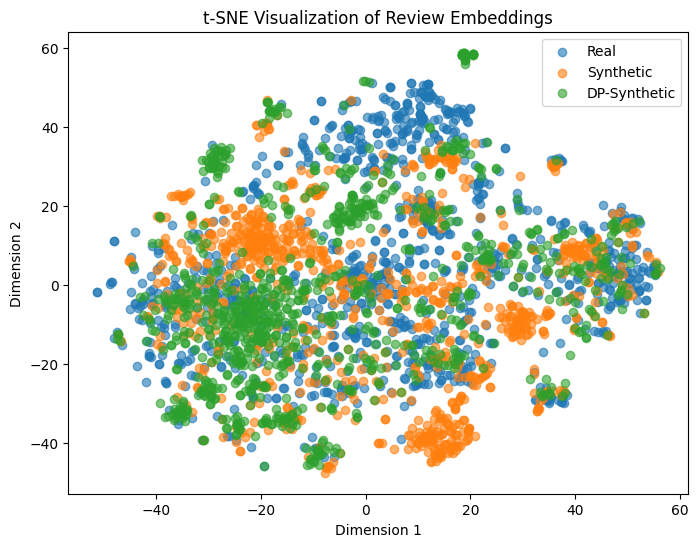

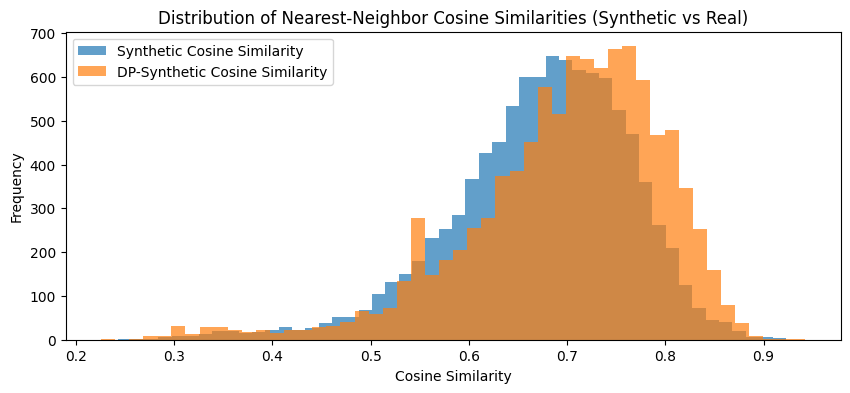

In [11]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

# Subsample embeddings for visualization (e.g., at most 1000 per dataset)
def subsample_embeddings(embeddings, texts, n=1000):
    if len(embeddings) > n:
        indices = random.sample(range(len(embeddings)), n)
        return embeddings[indices], [texts[i] for i in indices]
    else:
        return embeddings, texts

# Subsample each embedding set (assuming real_texts, synth_texts, and dp_synth_texts are defined)
real_emb_sample, _ = subsample_embeddings(emb_real, real_texts, n=1000)
synth_emb_sample, _ = subsample_embeddings(emb_synth, synth_texts, n=1000)
dp_emb_sample, _ = subsample_embeddings(emb_dp_synth, dp_synth_texts, n=1000)

# Combine for t-SNE
X_combined = np.vstack([real_emb_sample, synth_emb_sample, dp_emb_sample])
labels = (['Real'] * len(real_emb_sample) +
          ['Synthetic'] * len(synth_emb_sample) +
          ['DP-Synthetic'] * len(dp_emb_sample))

# Run t-SNE to reduce embeddings to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_combined)

# Create scatter plot for t-SNE results
plt.figure(figsize=(8, 6))
for dataset in ['Real', 'Synthetic', 'DP-Synthetic']:
    idx = [i for i, lab in enumerate(labels) if lab == dataset]
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=dataset, alpha=0.6)
plt.title('t-SNE Visualization of Review Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

# ---------------------------------------------------------------------
# Histogram of Nearest-Neighbor Cosine Similarities
# For each synthetic review, find the nearest neighbor in the real dataset using cosine distance.
nbrs = NearestNeighbors(n_neighbors=1, metric='cosine').fit(emb_real)
distances_synth, _ = nbrs.kneighbors(emb_synth)
cosine_sims_synth = 1 - distances_synth  # Convert cosine distance to similarity

nbrs_dp = NearestNeighbors(n_neighbors=1, metric='cosine').fit(emb_real)
distances_dp, _ = nbrs_dp.kneighbors(emb_dp_synth)
cosine_sims_dp = 1 - distances_dp

# Plot histograms of cosine similarities for Synthetic and DP-Synthetic datasets
plt.figure(figsize=(10, 4))
plt.hist(cosine_sims_synth, bins=50, alpha=0.7, label='Synthetic Cosine Similarity')
plt.hist(cosine_sims_dp, bins=50, alpha=0.7, label='DP-Synthetic Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Nearest-Neighbor Cosine Similarities (Synthetic vs Real)')
plt.legend()
plt.show()


### 1.2 b. Cosine similarity and Frechet distance

In [12]:
from sklearn.neighbors import NearestNeighbors
from scipy.linalg import sqrtm
from sklearn.model_selection import train_test_split
import numpy as np

# Cosine similarity: find nearest neighbor in real embeddings for each synthetic embedding
nbrs = NearestNeighbors(n_neighbors=1, metric='cosine').fit(emb_real)

# For non-DP synthetic
distances, _ = nbrs.kneighbors(emb_synth)
# sklearn returns cosine *distance* (where 0 = identical, 1 = orthogonal). Cosine similarity = 1 - distance.
cos_sims = 1 - distances
avg_cos_sim_synth = float(np.mean(cos_sims))

# For DP synthetic
distances_dp, _ = nbrs.kneighbors(emb_dp_synth)
cos_sims_dp = 1 - distances_dp
avg_cos_sim_dp = float(np.mean(cos_sims_dp))

print("Average nearest-neighbor cosine similarity to Real (Synthetic): {:.3f}".format(avg_cos_sim_synth))
print("Average nearest-neighbor cosine similarity to Real (DP-Synthetic): {:.3f}".format(avg_cos_sim_dp))

# Fréchet Distance (embedding distributions)
def frechet_distance(mu1, cov1, mu2, cov2):
    """Compute Fréchet distance between two Gaussian distributions with means mu and covariances cov."""
    diff = mu1 - mu2
    # sqrt of product of covariances
    cov_prod = sqrtm(cov1.dot(cov2))
    # Numerical stability: ensure no imaginary component from sqrtm
    if np.iscomplexobj(cov_prod):
        cov_prod = cov_prod.real
    dist = diff.dot(diff) + np.trace(cov1 + cov2 - 2*cov_prod)
    return float(dist)

# Mean and covariance for each distribution
mu_real      = np.mean(emb_real, axis=0)
mu_synth     = np.mean(emb_synth, axis=0)
mu_dp_synth  = np.mean(emb_dp_synth, axis=0)
cov_real     = np.cov(emb_real, rowvar=False)
cov_synth    = np.cov(emb_synth, rowvar=False)
cov_dp_synth = np.cov(emb_dp_synth, rowvar=False)

fid_synth    = frechet_distance(mu_real, cov_real, mu_synth, cov_synth)
fid_dp_synth = frechet_distance(mu_real, cov_real, mu_dp_synth, cov_dp_synth)

print("Fréchet Distance (Real vs Synthetic): {:.3f}".format(fid_synth))
print("Fréchet Distance (Real vs DP-Synthetic): {:.3f}".format(fid_dp_synth))

# Baseline FD: Compare two splits of real data
# For text embeddings, there isn’t a universal scale; you should compare the FD of your synthetic data against a baseline.
# If the FD between synthetic and real data is close to the FD computed between two subsets of real data, that indicates high fidelity.
emb_real1, emb_real2 = train_test_split(emb_real, test_size=0.5, random_state=42)
mu_real1 = np.mean(emb_real1, axis=0)
cov_real1 = np.cov(emb_real1, rowvar=False)
mu_real2 = np.mean(emb_real2, axis=0)
cov_real2 = np.cov(emb_real2, rowvar=False)
fid_baseline = frechet_distance(mu_real1, cov_real1, mu_real2, cov_real2)

print("Baseline Fréchet Distance (Real vs Real split): {:.3f}".format(fid_baseline))


Average nearest-neighbor cosine similarity to Real (Synthetic): 0.673
Average nearest-neighbor cosine similarity to Real (DP-Synthetic): 0.698
Fréchet Distance (Real vs Synthetic): 0.191
Fréchet Distance (Real vs DP-Synthetic): 0.184
Baseline Fréchet Distance (Real vs Real split): 0.015


The baseline FD (0.017) represents the inherent variability within your real data. In contrast, both the synthetic (0.196) and DP-synthetic (0.189) datasets show Fréchet Distances that are roughly an order of magnitude higher.

In the context of text embeddings, a cosine similarity of 0.7 might mean that while the texts are related in meaning or topic, there are still noticeable differences in nuance or details.








### 1.3: Human evaluation

In [13]:
import random
import pandas as pd

# Sample 5% (or at most 1000) reviews from a list of texts
def sample_reviews(texts, frac=0.05, cap=1000):
    n = len(texts)
    k = min(int(n * frac), cap)
    return random.sample(texts, k)

# Sample reviews from each dataset
sample_real = sample_reviews(real_texts)
sample_synth = sample_reviews(synth_texts)
sample_dp_synth = sample_reviews(dp_synth_texts)

# Ensure that all three samples have the same number of reviews
n_samples = min(len(sample_real), len(sample_synth), len(sample_dp_synth))
sample_real = sample_real[:n_samples]
sample_synth = sample_synth[:n_samples]
sample_dp_synth = sample_dp_synth[:n_samples]

# Create a DataFrame with one review from each dataset in a single row
sample_df = pd.DataFrame({
    'Real': sample_real,
    'Synthetic': sample_synth,
    'DP-Synthetic': sample_dp_synth
})

# Save the DataFrame to CSV
sample_df.to_csv('fidelity_human_samples_side_by_side.csv', index=False)
print(f"Saved {len(sample_df)} rows with side-by-side reviews to 'fidelity_human_samples_side_by_side.csv' for manual evaluation.")


Saved 500 rows with side-by-side reviews to 'fidelity_human_samples_side_by_side.csv' for manual evaluation.


### 1.4 Jensen-Shannon Divergence (Word Distribution)
As an alternative quantitative measure, we compute the Jensen-Shannon Divergence (JSD) between the word distributions of real and synthetic datasets. This measures how similar the overall word usage is. We focus on the top frequent words to avoid heavy computation on the entire vocabulary. A lower JSD (closer to 0) means the two distributions are very similar, while higher values indicate differences in word usage patterns.

In [14]:
from collections import Counter

def jensen_shannon_divergence(texts1, texts2, top_n=1000):
    """Compute JSD between word frequency distributions of two text sets."""
    words1 = [w for text in texts1 for w in text.split()]
    words2 = [w for text in texts2 for w in text.split()]
    freq1 = Counter(words1)
    freq2 = Counter(words2)
    # Determine vocabulary: top N words from each set
    vocab1 = [w for w, _ in freq1.most_common(top_n)]
    vocab2 = [w for w, _ in freq2.most_common(top_n)]
    vocab = list(set(vocab1) | set(vocab2))
    # Construct probability vectors for this vocabulary
    P = np.array([freq1.get(w, 0) for w in vocab], dtype=float)
    Q = np.array([freq2.get(w, 0) for w in vocab], dtype=float)
    # Normalize to probabilities
    P /= P.sum() if P.sum() > 0 else 1
    Q /= Q.sum() if Q.sum() > 0 else 1
    M = 0.5 * (P + Q)
    # Compute KLD(P||M) and KLD(Q||M) with care to avoid log(0)
    mask_P = P > 0
    mask_Q = Q > 0
    KLD_PM = np.sum(P[mask_P] * np.log2(P[mask_P] / M[mask_P]))
    KLD_QM = np.sum(Q[mask_Q] * np.log2(Q[mask_Q] / M[mask_Q]))
    JSD = 0.5 * (KLD_PM + KLD_QM)
    return float(JSD)

jsd_synth = jensen_shannon_divergence(real_texts, synth_texts, top_n=1000)
jsd_dp_synth = jensen_shannon_divergence(real_texts, dp_synth_texts, top_n=1000)
print("JSD (word distribution: Real vs Synthetic) = {:.3f}".format(jsd_synth))
print("JSD (word distribution: Real vs DP-Synthetic) = {:.3f}".format(jsd_dp_synth))


JSD (word distribution: Real vs Synthetic) = 0.131
JSD (word distribution: Real vs DP-Synthetic) = 0.129


 both synthetic datasets exhibit high fidelity in terms of word distribution relative to the real data, which is a positive sign for the quality of the synthetic generation process.

## Metric 2 - Utility Evaluation

Here we assess how useful the synthetic data is for modeling tasks. We do this by training a model on one dataset and testing on another, and by comparing feature importance (which factors are most predictive) when training on real vs. synthetic.

### 2.1 Train on Synthetic, Test on Real (TSTR) and Vice Versa

We use the real dataset's training set (train_texts and train_labels from our earlier split) and the held-out real test set (test_texts, test_labels). We will train three logistic regression models:
1. Real->Real (Baseline): Train on train_texts (real data), test on test_texts (real data).
2. Synthetic->Real (TSTR): Train on all synthetic data, test on test_texts (real data).
3. DP-Synthetic->Real (TSTR with DP data): Train on all DP-synthetic data, test on test_texts.


Additionally, we'll test the model trained on real data against synthetic data:
1. Real->Synthetic: Use the model trained on real (from baseline) to predict labels on the synthetic dataset.
2. Real->DP-Synthetic: Use the same real-trained model to predict on DP-synthetic data.


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Prepare data for training
synth_texts = synth_df['review'].astype(str).tolist()
synth_labels = synth_df['label'].tolist()
dp_synth_texts = dp_synth_df['review'].astype(str).tolist()
dp_synth_labels = dp_synth_df['label'].tolist()

# Baseline: Train on real (train_texts), test on real (test_texts)
vect_real = TfidfVectorizer(max_features=5000)
X_train_real = vect_real.fit_transform(train_texts)
X_test_real = vect_real.transform(test_texts)
clf_real = LogisticRegression(max_iter=1000)
clf_real.fit(X_train_real, train_labels)
pred_test_real = clf_real.predict(X_test_real)
acc_real_real = accuracy_score(test_labels, pred_test_real)

# Train on synthetic (non-DP), test on real
vect_synth = TfidfVectorizer(max_features=5000)
X_train_synth = vect_synth.fit_transform(synth_texts)
X_test_real_from_synth = vect_synth.transform(test_texts)  # transform real test with synthetic vectorizer
clf_synth = LogisticRegression(max_iter=1000)
clf_synth.fit(X_train_synth, synth_labels)
pred_test_real_from_synth = clf_synth.predict(X_test_real_from_synth)
acc_synth_real = accuracy_score(test_labels, pred_test_real_from_synth)

# Train on DP-synthetic, test on real
vect_dp = TfidfVectorizer(max_features=5000)
X_train_dp = vect_dp.fit_transform(dp_synth_texts)
X_test_real_from_dp = vect_dp.transform(test_texts)
clf_dp = LogisticRegression(max_iter=1000)
clf_dp.fit(X_train_dp, dp_synth_labels)
pred_test_real_from_dp = clf_dp.predict(X_test_real_from_dp)
acc_dp_real = accuracy_score(test_labels, pred_test_real_from_dp)

# Use the real-trained model to test on synthetic data (non-DP and DP)
# (We use the vect_real trained on real train data to transform synthetic texts)
X_synth_as_test = vect_real.transform(synth_texts)
X_dp_synth_as_test = vect_real.transform(dp_synth_texts)
pred_synth_by_real = clf_real.predict(X_synth_as_test)
pred_dp_synth_by_real = clf_real.predict(X_dp_synth_as_test)
acc_real_synth = accuracy_score(synth_labels, pred_synth_by_real)
acc_real_dp_synth = accuracy_score(dp_synth_labels, pred_dp_synth_by_real)

# Print accuracy results
print("Accuracy (Train Real -> Test Real) [baseline]       : {:.3f}".format(acc_real_real))
print("Accuracy (Train Synthetic -> Test Real) (TSTR)      : {:.3f}".format(acc_synth_real))
print("Accuracy (Train DP-Synthetic -> Test Real) (TSTR)   : {:.3f}".format(acc_dp_real))
print("Accuracy (Train Real -> Test Synthetic)             : {:.3f}".format(acc_real_synth))
print("Accuracy (Train Real -> Test DP-Synthetic)          : {:.3f}".format(acc_real_dp_synth))


Accuracy (Train Real -> Test Real) [baseline]       : 0.868
Accuracy (Train Synthetic -> Test Real) (TSTR)      : 0.850
Accuracy (Train DP-Synthetic -> Test Real) (TSTR)   : 0.851
Accuracy (Train Real -> Test Synthetic)             : 0.903
Accuracy (Train Real -> Test DP-Synthetic)          : 0.863


In [16]:
# prompt: groupby rating synth_df

# Assuming synth_df is your DataFrame
grouped_synth_df = synth_df.groupby('rating')

# Example: Print the size of each group
for rating, group in grouped_synth_df:
    print(f"Rating: {rating}, Number of reviews: {len(group)}")

# Example: Access a specific group
rating_5_reviews = grouped_synth_df.get_group(5)
print(rating_5_reviews.head())


Rating: 1, Number of reviews: 897
Rating: 2, Number of reviews: 515
Rating: 3, Number of reviews: 786
Rating: 4, Number of reviews: 1385
Rating: 5, Number of reviews: 6417
   rating                                        title  \
1       5          Awesome!  Great price!  Works well!   
2       5           Worked but took an hour to install   
4       5                                     LOVE IT!   
5       5  Works Great with my IPhone 13 & Magna Case!   
6       5                 Great item! Easy to install!   

                                              review  label  
1  i.imgur.com/tj5p1Xq<br /><br />Works great and...      1  
2  en.wikipedia.org/2019/2/21/How_to_install_scre...      1  
4  "Love it! Very pretty and fits perfectly. I ha...      1  
5  I really like the fact that it is small and co...      1  
6  "Great item! Easy to install! Fast delivery! G...      1  


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Assume real_df, synth_df, and dp_synth_df are already loaded from JSONL files.
# For multi-class rating prediction, we use the "rating" column.

# Prepare real data: use the full rating (e.g., 1 to 5)
real_texts = real_df['review'].astype(str).tolist()
real_ratings = real_df['rating'].tolist()

# Split real data into train and test sets (80/20 split)
train_texts, test_texts, train_ratings, test_ratings = train_test_split(
    real_texts, real_ratings, test_size=0.2, random_state=42
)

# Prepare synthetic datasets: use the "rating" column as target
synth_texts = synth_df['review'].astype(str).tolist()
synth_ratings = synth_df['rating'].tolist()
dp_synth_texts = dp_synth_df['review'].astype(str).tolist()
dp_synth_ratings = dp_synth_df['rating'].tolist()

# # ---------------------------
# # Baseline: Train on real reviews, test on real reviews
# # ---------------------------
# vect_real = TfidfVectorizer(max_features=5000)
# X_train_real = vect_real.fit_transform(train_texts)
# X_test_real = vect_real.transform(test_texts)

# # Use logistic regression for multi-class classification
# clf_real = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
# clf_real.fit(X_train_real, train_ratings)
# pred_test_real = clf_real.predict(X_test_real)
# acc_real_real = accuracy_score(test_ratings, pred_test_real)

# # ---------------------------
# # Train on synthetic (non-DP) reviews, test on real reviews (TSTR)
# # ---------------------------
# vect_synth = TfidfVectorizer(max_features=5000)
# X_train_synth = vect_synth.fit_transform(synth_texts)
# X_test_real_from_synth = vect_synth.transform(test_texts)  # Transform real test reviews using synthetic vectorizer

# clf_synth = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
# clf_synth.fit(X_train_synth, synth_ratings)
# pred_test_real_from_synth = clf_synth.predict(X_test_real_from_synth)
# acc_synth_real = accuracy_score(test_ratings, pred_test_real_from_synth)

# # ---------------------------
# # Train on DP-synthetic reviews, test on real reviews (TSTR)
# # ---------------------------
# vect_dp = TfidfVectorizer(max_features=5000)
# X_train_dp = vect_dp.fit_transform(dp_synth_texts)
# X_test_real_from_dp = vect_dp.transform(test_texts)

# clf_dp = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
# clf_dp.fit(X_train_dp, dp_synth_ratings)
# pred_test_real_from_dp = clf_dp.predict(X_test_real_from_dp)
# acc_dp_real = accuracy_score(test_ratings, pred_test_real_from_dp)

# # ---------------------------
# # Use the real-trained model to test on synthetic reviews (Reverse)
# # ---------------------------
# X_synth_as_test = vect_real.transform(synth_texts)
# X_dp_synth_as_test = vect_real.transform(dp_synth_texts)
# pred_synth_by_real = clf_real.predict(X_synth_as_test)
# pred_dp_synth_by_real = clf_real.predict(X_dp_synth_as_test)
# acc_real_synth = accuracy_score(synth_ratings, pred_synth_by_real)
# acc_real_dp_synth = accuracy_score(dp_synth_ratings, pred_dp_synth_by_real)

# # ---------------------------
# # Print accuracy results for all scenarios
# # ---------------------------
# print("Accuracy (Train Real -> Test Real) [baseline]       : {:.3f}".format(acc_real_real))
# print("Accuracy (Train Synthetic -> Test Real) (TSTR)      : {:.3f}".format(acc_synth_real))
# print("Accuracy (Train DP-Synthetic -> Test Real) (TSTR)   : {:.3f}".format(acc_dp_real))
# print("Accuracy (Train Real -> Test Synthetic)             : {:.3f}".format(acc_real_synth))
# print("Accuracy (Train Real -> Test DP-Synthetic)          : {:.3f}".format(acc_real_dp_synth))


#finetune LLM

In [22]:
!pip install -q transformers datasets peft

import os
import torch
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, LlamaForSequenceClassification, Trainer, TrainingArguments
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.metrics import accuracy_score

# -------------------------------
# 1. Device and Model Setup
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_name = "meta-llama/Llama-3.2-1B"  # your 1B LLaMA model identifier

# Load tokenizer and ensure a pad token exists
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token

# Load model for sequence classification (5 classes: ratings 0-4)
model = LlamaForSequenceClassification.from_pretrained(
    model_name,
    num_labels=5,
    torch_dtype=torch.float16,
    device_map="auto"
)
model.config.pad_token_id = tokenizer.pad_token_id

# Freeze all base parameters
for param in model.parameters():
    param.requires_grad = False

# -------------------------------
# 2. Apply LoRA for PEFT
# -------------------------------
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj"]
)
model = get_peft_model(model, lora_config)
print("LoRA applied. Trainable parameters:")
model.print_trainable_parameters()
model.to(device)
model.train()
model.config.gradient_checkpointing = True

# -------------------------------
# 3. Prepare Hugging Face Datasets
# -------------------------------
# Use your existing in‑memory data splits.
# (Ensure ratings are 0–4; if originally 1–5, subtract 1)
train_data = {"text": train_texts, "label": train_ratings}
test_data  = {"text": test_texts, "label": test_ratings}

train_dataset = Dataset.from_dict(train_data)
test_dataset  = Dataset.from_dict(test_data)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset  = test_dataset.map(tokenize_function, batched=True)

# Remove the raw text column and set format for PyTorch
train_dataset = train_dataset.remove_columns(["text"])
test_dataset  = test_dataset.remove_columns(["text"])
train_dataset.set_format("torch")
test_dataset.set_format("torch")

# -------------------------------
# 4. Define Trainer and TrainingArguments
# -------------------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

training_args = TrainingArguments(
    output_dir="./llama_results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# -------------------------------
# 5. Fine-Tune and Evaluate
# -------------------------------
trainer.train()
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

# -------------------------------
# 6. Save the Fine-Tuned Model
# -------------------------------
save_directory = "./finetuned_llama_classification"
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)
print(f"Model and tokenizer saved to {save_directory}")


Using device: cuda


Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LoRA applied. Trainable parameters:
trainable params: 4,335,616 || all params: 1,240,160,256 || trainable%: 0.3496


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
import torch
import gc

# Clear PyTorch's CUDA cache
torch.cuda.empty_cache()

# Optionally, force garbage collection to free up memory
gc.collect()


In [ ]:
torch.cuda.synchronize()

In [21]:
print(test_ratings)

[5, 5, 2, 4, 5, 5, 1, 5, 5, 5, 5, 3, 1, 5, 5, 5, 5, 2, 5, 3, 4, 5, 2, 1, 5, 5, 5, 1, 5, 5, 1, 5, 5, 1, 5, 4, 2, 5, 5, 3, 5, 1, 5, 5, 5, 5, 5, 5, 3, 2, 3, 1, 5, 5, 5, 5, 1, 1, 4, 5, 5, 2, 2, 5, 1, 5, 2, 5, 5, 4, 5, 5, 1, 5, 4, 5, 5, 2, 1, 5, 2, 5, 5, 4, 5, 4, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 4, 4, 5, 1, 4, 5, 5, 5, 1, 5, 5, 4, 2, 5, 5, 5, 4, 3, 4, 5, 5, 5, 5, 4, 2, 4, 5, 5, 4, 5, 5, 5, 2, 5, 3, 5, 5, 4, 3, 5, 5, 4, 5, 2, 5, 3, 4, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 1, 5, 5, 3, 5, 5, 3, 1, 5, 5, 5, 5, 1, 5, 5, 5, 5, 1, 5, 5, 4, 5, 2, 4, 1, 3, 5, 5, 5, 4, 1, 3, 5, 5, 5, 5, 3, 4, 2, 5, 5, 2, 3, 5, 5, 5, 5, 3, 5, 2, 5, 5, 5, 5, 5, 5, 2, 3, 5, 5, 1, 3, 5, 5, 5, 5, 3, 5, 5, 1, 5, 5, 5, 5, 4, 5, 1, 3, 5, 5, 5, 5, 5, 5, 4, 2, 1, 3, 2, 5, 3, 4, 3, 4, 5, 4, 5, 5, 5, 4, 2, 3, 5, 3, 5, 1, 5, 5, 3, 5, 3, 1, 5, 5, 5, 4, 4, 5, 4, 5, 5, 5, 3, 5, 5, 4, 5, 5, 5, 5, 2, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 1, 5, 5, 5, 2, 5, 1, 1, 5, 3, 3, 5, 4, 5, 1, 5, 5, 5, 

In [33]:
train_dataset.features

{'label': Value(dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [34]:
# Print the first 5 examples from the train_dataset
print("First 5 examples from train_dataset:")
for i in range(5):
    print(f"Example {i}: {train_dataset[i]}")

# Alternatively, convert to a Pandas DataFrame and display the first few rows:
import pandas as pd
df_train = train_dataset.to_pandas()
print(df_train.head())


First 5 examples from train_dataset:
Example 0: {'label': tensor(4), 'input_ids': tensor([128000,     40,   3287,    956,    617,    264,   2559,    389,    856,
          4641,     11,    323,    420,    832,   3727,    433,   4832,    311,
           617,    279,   4641,  49685,     13,   1115,   3727,    279,   4459,
          4641,   3504,   3245,  17251,    323,   4228,    311,    990,    449,
            13,    578,   1023,   3245,    374,    279,  25703,    389,    279,
          3769,    330,     64,   2536,  37557,      1,   3769,    374,  26222,
         16134,   1347,  24930,   1347,   6338,   2675,  13524,    617,   9313,
           369,    279,   1203,    315,    279,   4641,     11,    323,  30194,
            11,    358,   1053,  32113,   9313,    369,    279,   4264,     11,
          1524,   3582,    279,    330,  34215,      1,   5825,   1063,   9313,
            13,   2030,     11,    279,   4124,   5825,  23900,   9313,     13,
           578,   2733,    374,   1695